## Imports

In [1]:
import scipy.io
import numpy as np
import math
from sklearn import linear_model 
from scipy import linalg
from sklearn import preprocessing as preproc # load preprocessing function
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
from sklearn.model_selection import KFold

# seaborn can be used to "prettify" default matplotlib plots by importing and setting as default
import seaborn as sns
sns.set() # Set searborn as default

## Load dataset

In [19]:
mat = scipy.io.loadmat('sand.mat')

X = mat['X']
y = mat['Y']

[n,p] = X.shape
seed = 42

### 1 Apply Least angle regression and selection (LARS) for the p >> n sand data set (X: data matrix with 59 observations and 2016 features, y: the measured moisture content in percent for each sand sample). Find a suitable solution using:

>(a) The Cp statistic. Consider whether the Cp-statistic makes sense in this case (p > n). Why? Why not?

>> (i) Hint: What happens to your estimate of the noise in the data?

In [12]:
# Estimate the noise of the data
# Calculate an unbiased OLS estimate using linalg.lstsq
beta_OLS = linalg.lstsq(X, y)[0]

sigma_hat2 = np.mean((y - X @ beta_OLS)**2)
sigma_hat2

1.2533618692417325e-24

<span style="color:yellow"> Since sigma_hat2 is almost 0, it doesn't make sense to use the Cp-statistic

>(b) Using Cross-validation. Remember to center y and normalize X, but do it inside
the cross validation!

In [47]:
X_train.shape

(47, 2016)

In [46]:
(X_train / d).shape

(47, 2016)

In [69]:
def centerData(data):
    
    mu = np.mean(data,axis=0)
    data = data - mu
    
    return data, mu

def normalize(X):
    d = np.linalg.norm(X, ord=2, axis=0)
    return X / d, d
# Set up cross validation like you did last week
CV = 5 # if K = n leave-one-out, you may try different numbers
kf = KFold(n_splits=CV, shuffle=True, random_state=seed)

# Set a suitable range of features that can be given to LARS as n_nonzero_coefs 
stop = n-math.ceil(n/CV)
K = range(1, stop)

Err_tr = np.zeros((CV,len(K)))
Err_tst = np.zeros((CV, len(K))) 
for i, (train_index, test_index) in enumerate(kf.split(X)):
    # print(i)
    # NOTE: If you normalize outside the CV loop the data implicitly carry information of the test data
    # We should perform CV "the right way" and keep test data unseen.
    X_train, mu_x = centerData(X[train_index])
    y_train, mu_y = centerData(y[train_index])
    X_test, y_test = X[test_index] - mu_x, y[test_index] - mu_y

    X_train, d = normalize(X_train)
    X_test = X_test / d
    # compute all LARS solutions inside each fold 
    for nj, j in enumerate(K):
        # print(nj)
        reg = linear_model.Lars(n_nonzero_coefs=j, fit_path = False, fit_intercept = False, verbose = True)
        reg.fit(X_train,y_train)
        beta = reg.coef_#.ravel()

        # e = np.mean((y_train - X_train @ beta.T)**2)
        # Predict with this model, and find both training and test error
        Err_tr[i, nj] = np.mean((y_train - X_train @ beta.T)**2)
        Err_tst[i, nj] = np.mean((y_test - X_test @ beta.T)**2)


err_tr = np.mean(Err_tr, axis=0) # mean training error over the CV folds
err_tst = np.mean(Err_tst, axis=0) # mean test error over the CV folds
err_ste = np.std(Err_tst, axis=0)/np.sqrt(CV) # Note: we divide with sqrt(n) to get the standard error as opposed to the standard deviation

In [72]:
# Compute Cp-statistic, assumption n > p
X_norm,_ = centerData(X)
X_norm,_ = normalize(X_norm)

# run LARS on all data and and vary the nonzero coefs from 0 to p. save the betas for Cp
Betas = np.zeros((p, n))
for j in range(1,n):
    reg = linear_model.Lars(n_nonzero_coefs=j)
    reg.fit(X_norm,y)
    Betas[:,i] = reg.coef_
    
# calculate Cp for each number of nonzero coefs
Cp = np.zeros((len(K)))
for j in range(len(K)):
    Yhat = X_norm @ Betas[:,K[j]]
    Cp[j] = np.mean(((y-Yhat)**2)) + 2*K[j]/n*sigma_hat2

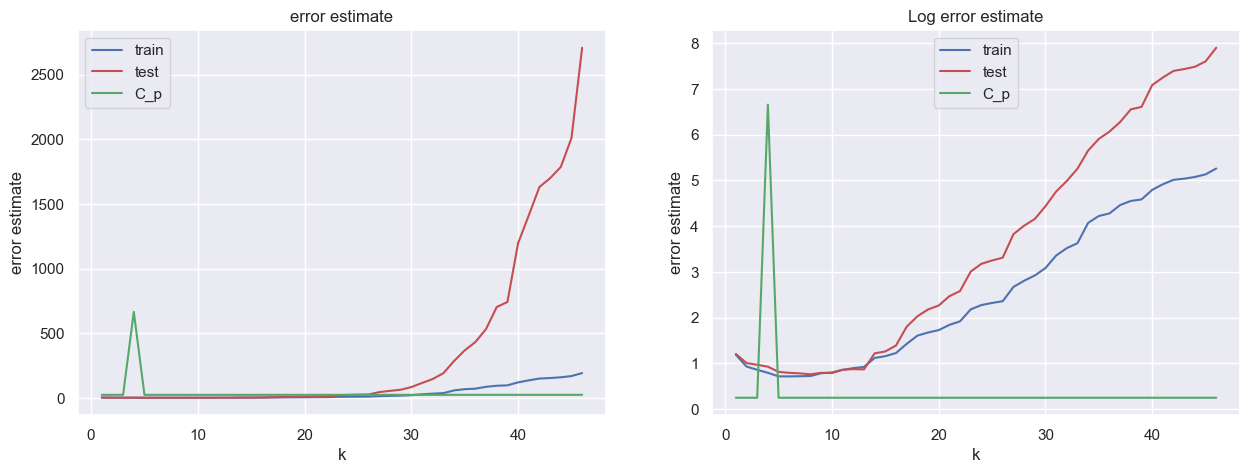

In [85]:
fig, ax = plt.subplots(1,2, figsize=(15,5))    
ax[0].plot(K, err_tr, 'b', label='train')
ax[0].plot(K, err_tst, 'r', label='test')
ax[0].plot(K, Cp/1e0, 'g', label= 'C_p') # scale to put in same plot
ax[0].legend()
ax[0].set_xlabel('k')
ax[0].set_ylabel('error estimate')
ax[0].set_title("error estimate")

ax[1].plot(K, np.log(err_tr), 'b', label='train')
ax[1].plot(K, np.log(err_tst), 'r', label='test')
ax[1].plot(K, Cp/1e2, 'g', label= 'C_p') # scale to put in same plot
ax[1].legend()
ax[1].set_xlabel('k')
ax[1].set_ylabel('error estimate')
ax[1].set_title("Log error estimate")
plt.show()